 # Conservative regridding SE-NEMO GS1p2_full

In [1]:
import numpy as np
import xarray as xr
import xgcm as xg
import xnemogcm as xn #import open_domain_cfg, open_nemo
import matplotlib.pyplot as plt

## Loading data and preparing the xarray dataset

We load the GOSI9_MEs domain_cfg.nc and the Tgrid output.

In [2]:
dir_dom_src = "/data/users/dbruciaf/SE-NEMO/se-orca025/se-nemo-domain_cfg/"
lst_dom_src = [dir_dom_src + "mesh_mask_MEs.nc"]
dir_out     = "/data/users/dbruciaf/SE-NEMO/se-orca025/GS1p2_full/"
lst_out     = [dir_out + "se-nemo_GS1p2_full_average_1991-2019_grid_T.nc"]
ds_src = xn.open_nemo_and_domain_cfg(nemo_files=lst_out, domcfg_files=lst_dom_src).chunk({'z_f': -1, 'z_c':-1})
ds_src = ds_src.squeeze().drop_vars(['t','time_centered','time_centered_bounds','t_bounds']).fillna(0)

We load the standard GOSI9_zps domain_cfg.nc

In [3]:
dir_dom_dst = "/data/users/dbruciaf/OVF/GOSI9-eORCA025/"
lst_dom_dst = ["mesh_mask.nc"]
ds_dst = xn.open_domain_cfg(datadir=dir_dom_dst, files=lst_dom_dst).chunk({'z_f': -1, 'z_c':-1})

We load the mask for the localisation area

In [5]:
loc_msk = "/data/users/dbruciaf/SE-NEMO/se-orca025/MEs_450-800_3200/bathymetry.loc_area.dep3200_polglo_sig3_itr1.MEs_4env_450_018-010-010_opt_v2_glo.nc"
ds_loc  = xr.open_dataset(loc_msk)
ds_loc  = ds_loc.rename_dims({'x':'x_c','y':'y_c'})
da_msk  = ds_loc.s2z_msk
da_msk  = da_msk.where(da_msk==0,1)
del ds_loc

We include the relevant variables in the `ds_src` dataset

In [6]:
ds_src['loc_msk']        = da_msk
ds_src['gdepw_0_target'] = ds_dst.gdepw_0
ds_src['gdept_0_target'] = ds_dst.gdept_0
ds_src['e3t_0_target']   = ds_dst.e3t_0
ds_src['tmask_target']   = ds_dst.tmask
ds_src = ds_src.set_coords(['gdepw_0_target','gdept_0_target'])
del ds_dst
#ds_src

We need to have an extensive variable for the conservative interpolation: let's use a proxy of the heat content (T * e3t).

In [7]:
ds_src['Hc'] = (ds_src.thetao_con * ds_src.e3t_0)
ds_src.Hc.attrs = {
    'standard_name':'heat content',
    'units':'K m'
}
#ds_src

We remove the deepest T point, which is always land in NEMO: needed for the vertical interpolation algorithm.

In [8]:
ds_src = ds_src.isel({'z_c':slice(None,-1)})
#ds_src

We create the `xgcm` grid object

In [9]:
grd_src = xg.Grid(ds_src, metrics=xn.get_metrics(ds_src), periodic=False)
grd_src

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   z_c --> outer
  * outer    z_f --> center
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center

## Conservative remapping

Defining the target depth array abd cleaning obsolete coordinates. Here will be the point where we cycle.

In [11]:
varW = ['x_c','y_c','gphit','glamt','gdepw_1d','gdepw_0','nav_lat','nav_lon','gdepw_0_target']
target_values = ds_src.gdepw_0_target.isel(x_c=990,y_c=830).drop(varW)
varT = ['x_c','y_c','gphit','glamt','gdept_1d','gdept_0','nav_lat','nav_lon','gdept_0_target']
target_e3t    = ds_src.e3t_0_target.isel(x_c=1050,y_c=1000).drop(varT)
#target_e3t

Conservative remapping from MEs to zps vertical coordinates

In [12]:
transformed_cons = grd_src.transform(
    ds_src.Hc,
    'Z',
    target_values,
    method='conservative',
    target_data=ds_src.gdepw_0
).compute()

transformed_cons = transformed_cons.rename({'z_f':'z_c'}).assign_coords({'z_c':ds_src.z_c})
#transformed_cons.coords

/data/users/dbruciaf/.conda/envs/pyogcm/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/data/users/dbruciaf/.conda/envs/pyogcm/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Recomputing temperature from the heat content defined on the new zps target grid

In [13]:
transformed_t_cons = transformed_cons / target_e3t
transformed_t_cons.compute()

<xarray.DataArray (y_c: 1207, x_c: 1442, z_c: 74)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * x_c       (x_c) int64 0 1 2 3 4 5 6 7 ... 1435 1436 1437 1438 1439 1440 1441
  * y_c       (y_c) int64 0 1 2 3 4 5 6 7 ... 1200 1201 1202 1203 1204 1205 1206
    gphit     (y_c, x_c) float64 -89.5 -89.5 -89.5 -89.5 ... 50.02 50.0 50.0
    glamt     (y_c, x_c) float64 72.75 73.0 73.25 73.5 ... 73.01 73.01 73.0 73.0
    nav_lat   (y_c, x_c) float64 0.0 0.0 0.0 0.0 0.0 ... 50.07 50.02 50.0 50.0
    nav_lon   (y_c, x_c) float64 0.0 0.0 0.0 0.0 0.0 ... 73.01 73.01 73.0 73.0
  * z_c       (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 64 65 66 67 68 69 70 71 72 73
    gdept_1d  (z_c) float64 0.5058 1.556 2.668 ... 5.292e+03 5.495e+03 5.698e+03

Applying land-sea masks

In [14]:
#transformed_t_cons.gdept_1d.data = ds_src.gdept_0_target.isel(x_c=1050,y_c=1000).drop(varT).data
transformed_t_cons = transformed_t_cons.where(ds_src.tmask_target == 1)
ds_src['thetao_con']  = ds_src.thetao_con.where(ds_src.tmask == 1)

## Some plots

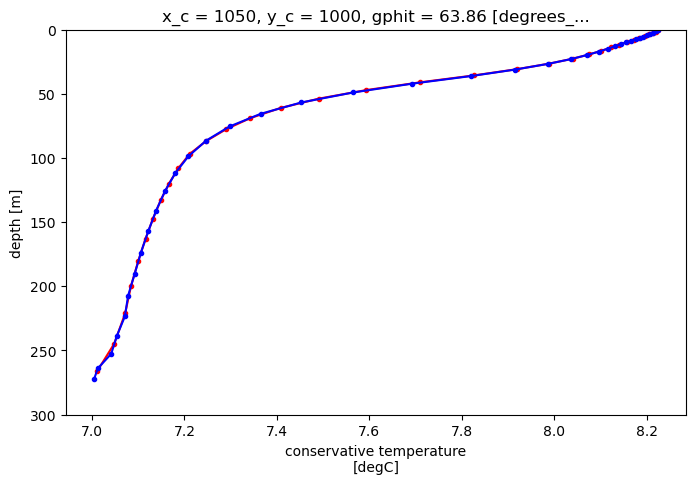

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
transformed_t_cons.isel(x_c=1050,y_c=1000).plot(y='gdept_0_target', color='r', marker='.', yincrease=False)
ds_src.thetao_con.isel(x_c=1050,y_c=1000).plot(y='gdept_0', color='b', marker='.', yincrease=False)
ax.set_ylim([300, 0])
plt.show()

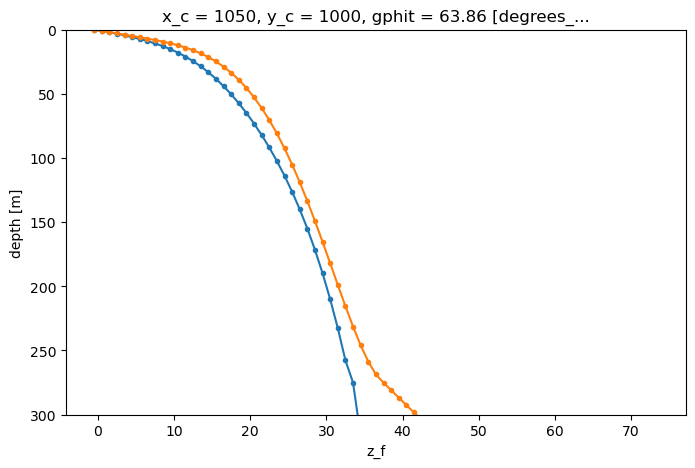

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ds_src.gdepw_0_target.isel(x_c=1050,y_c=1000).plot(ax=ax, x='z_f', marker = '.', yincrease=False)
ds_src.gdepw_0.isel(x_c=1050,y_c=1000).plot(ax=ax, x='z_f', marker = '.', yincrease=False)
ax.set_ylim([300, 0])
plt.show()

## Checking that the heat content is actually conserved

In [15]:
transformed_cons.isel(t=0,x_c=1050,y_c=1000).sum().values - ds_src.Hc.isel(t=0,x_c=1050,y_c=1000).sum().values

0.0